# Import Packages

In [1]:
import warnings 
warnings.simplefilter(action='ignore')
import pandas as pd
import os
import sys
parent_path = os.path.join(os.getcwd(), '..')
if parent_path not in sys.path:
    sys.path.append(parent_path)
import pickle
from pypinyin import pinyin, Style

import numpy as np
from utility.utils import select_model, autoregressive_predicting
from utility.data import data_imputer, data_slicing, \
    transformer_slice, get_dict_from_pd, train_test_split
from utility.visuals import plot_time_series, yield_visuals
from model.gpt import GPT_fit, GPT_predict, get_desired_sequence
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, \
AdaBoostRegressor
from IPython.display import clear_output
from tqdm import tqdm


# Retrieve Data

In [2]:

with open('../data/source_data.pkl', 'rb') as f:
    df = pickle.load(f)
df_list, date_range = data_imputer(df)
date_num = date_range.values
sequences = get_dict_from_pd(df_list, 'address1', '受傷')

# Data splitting / slicing

  0%|          | 0/22 [00:00<?, ?it/s]

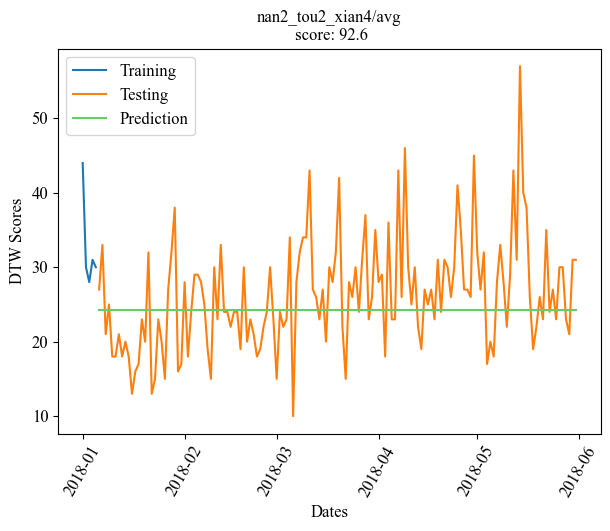

100%|██████████| 145/145 [00:00<00:00, 3434.17it/s]


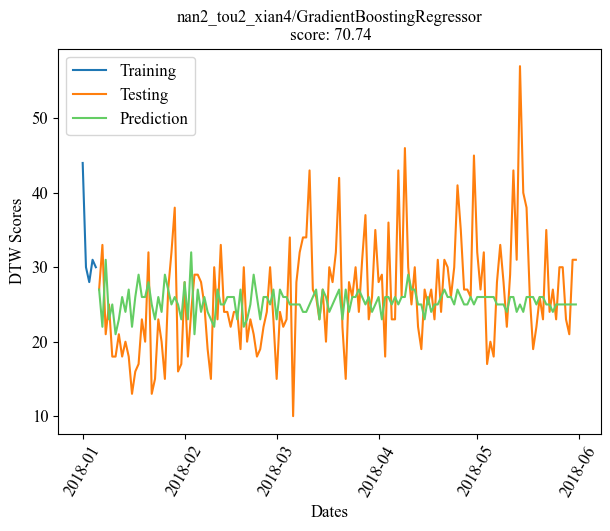

100%|██████████| 145/145 [00:01<00:00, 74.63it/s]


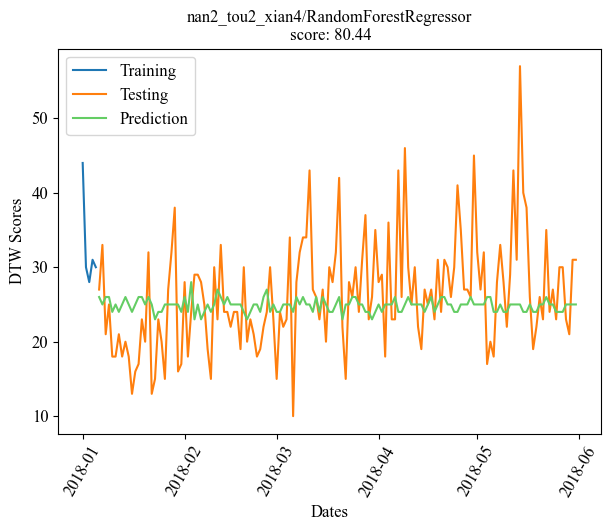

100%|██████████| 145/145 [00:01<00:00, 137.73it/s]


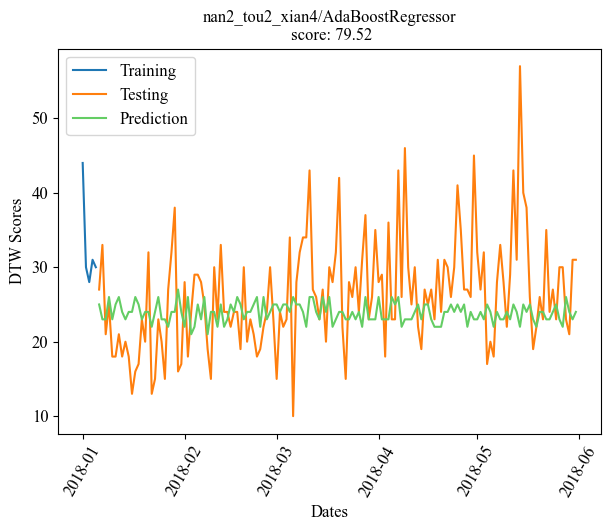

No checkpoint found. Training a new model...


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/22 [04:51<?, ?it/s]

{'loss': 3.0776, 'grad_norm': 3.971815824508667, 'learning_rate': 0.0005454545454545455, 'epoch': 9.09}


  0%|          | 0/22 [09:33<?, ?it/s]

{'loss': 2.847, 'grad_norm': 10.047588348388672, 'learning_rate': 9.090909090909092e-05, 'epoch': 18.18}


  0%|          | 0/22 [10:12<?, ?it/s]


KeyboardInterrupt: 

In [3]:
import torch

prediction_map = {}
device = torch.device('cpu')
for curr_address in tqdm(sequences.keys()):
    length = sequences[curr_address].shape[0]
    train, test = train_test_split(sequences[curr_address], length)
    train_x, train_y, final_segment = data_slicing(train, 150)
    train_x_g, train_y_g, final_segment = transformer_slice(train, 150)
    pinyin_result = pinyin(curr_address, style=Style.TONE3)
    
    roman_representation = "_".join([item[0] for item in pinyin_result])
    # plot_time_series(train, test, xticks=date_num, title=roman_representation, pred=np.array([]), saving=True)
    plot_time_series(train, test, xticks=date_num, title=roman_representation \
                 + "/avg\n", pred=np.mean(train) * np.ones_like(test), saving=True, train_limit=5, figsize=(7, 5))    
    g_loss = yield_visuals(GradientBoostingRegressor, final_segment, {},\
                train_x, train_y, train, test, date_num, roman_representation, saving=True, train_limit=5, figsize=(7, 5))
    r_loss = yield_visuals(RandomForestRegressor, final_segment, {},\
                train_x, train_y, train, test, date_num, roman_representation, saving=True, train_limit=5, figsize=(7, 5))
    a_loss = yield_visuals(AdaBoostRegressor, final_segment, {},\
                train_x, train_y, train, test, date_num, roman_representation, saving=True, train_limit=5, figsize=(7, 5))
        
    trainer, model, final_segment = GPT_fit(train, checkpoint_dir='../output/result/' + roman_representation, trained=True, device=device)
    pred = GPT_predict(model, final_segment, 300, device=device)
    pred_list = get_desired_sequence(pred, final_segment, test)
    gpt_loss = plot_time_series(train, test, xticks=date_num, pred=pred_list, title=roman_representation + "_GPT", saving=True, train_limit=5, figsize=(7, 5))
    
    ran = select_model(RandomForestRegressor, {}, train_x, train_y)
    ran_pred = autoregressive_predicting(ran, final_segment, len(test))
    
    prediction_map[roman_representation] = {
        'GradientBoost': g_loss['dtw'],
        'RandomForest': r_loss['dtw'],
        'Adaboost': a_loss['dtw'],
        'GPT': gpt_loss['dtw']
    }


    # clear_output(wait=True)



In [ ]:
# with open('../output/loss.pkl', 'wb') as f:
#     pickle.dump(prediction_map, f)


In [ ]:
import matplotlib.pyplot as plt
with open('../output/loss.pkl', 'rb') as f:
    prediction_map = pickle.load(f)

gradient_list = []
random_list = []
ada_list = []
GPT_list = []
for losses in list(prediction_map.values()):
    gradient_list.append(losses['GradientBoost'])
    random_list.append(losses['RandomForest'])
    ada_list.append(losses['Adaboost'])
    GPT_list.append(losses['GPT'])
num_sequences = len(sequences)
bar_width = .2
indices = np.arange(num_sequences)

plt.figure(figsize=(12, 6))

# Calculate the positions for each set of bars
positions_gradient = indices - 1.5 * bar_width
positions_random = indices - 0.5 * bar_width
positions_ada = indices + 0.5 * bar_width
positions_GPT = indices + 1.5 * bar_width
xticks = np.array([    "_".join([item[0] for item in pinyin(k, style=Style.TONE3)]) for k in sequences.keys()])
plt.bar(positions_gradient, gradient_list, width=bar_width, label='Gradient_boost')
plt.bar(positions_ada, ada_list, width=bar_width, label='Adaboost')
plt.bar(positions_random, random_list, width=bar_width, label='Random forest')
plt.bar(positions_GPT, GPT_list, width=bar_width, label='GPT')
plt.xticks(indices, xticks, rotation=60)
plt.title("DTW(dynamic time warping) scores by different models")
plt.xlabel("city")
plt.ylabel('dtw')
plt.legend()
plt.show()

In [ ]:
# Set the IEEE style font and font sizes to 12
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Load the prediction map
with open('../output/loss.pkl', 'rb') as f:
    prediction_map = pickle.load(f)

# Prepare lists for the losses for each model
gradient_list = []
random_list = []
ada_list = []
GPT_list = []

for losses in list(prediction_map.values()):
    gradient_list.append(losses['GradientBoost'])
    random_list.append(losses['RandomForest'])
    ada_list.append(losses['Adaboost'])
    GPT_list.append(losses['GPT'])

# Assume 'sequences' is a dictionary of sequences; update accordingly if needed
num_sequences = len(sequences)
bar_width = 0.2
indices = np.arange(num_sequences)

# Create a high-DPI figure
fig, ax = plt.subplots(figsize=(12, 7), dpi=700)

# Calculate positions for each set of bars
positions_gradient = indices - 1.5 * bar_width
positions_random   = indices - 0.5 * bar_width
positions_ada      = indices + 0.5 * bar_width
positions_GPT      = indices + 1.5 * bar_width

# Generate x-axis tick labels from the sequences (using pinyin conversion)
xticks = np.array([
    "_".join([item[0] for item in pinyin(k, style=Style.TONE3)])
    for k in sequences.keys()
])

# Plot the bars with distinct colors and IEEE-friendly styles
ax.bar(positions_gradient, gradient_list, width=bar_width, label='Gradient Boost', color='black')
ax.bar(positions_random, random_list, width=bar_width, label='Random Forest', color='gray')
ax.bar(positions_ada, ada_list, width=bar_width, label='Adaboost', color='dimgray')
ax.bar(positions_GPT, GPT_list, width=bar_width, label='GPT', color='red')

# Set x-ticks and labels with a 60° rotation
ax.set_xticks(indices)
ax.set_xticklabels(xticks, rotation=60)

# Set the title and axis labels with bold title styling
ax.set_title("DTW (Dynamic Time Warping) Scores by Different Models", fontweight='bold')
ax.set_xlabel("City")
ax.set_ylabel("DTW Score")

# Configure the legend without a frame
ax.legend(frameon=False, prop={'family': 'Times New Roman', 'size': 12})

# Remove the top and right spines for a cleaner IEEE-style appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
pd.DataFrame(prediction_map).T.mean()